# Computing the mean using `Pipe`

In this notebook, we compute the mean of an array of random numbers.  

Rather than import NumPy, we will use the `%pylab` magic command, which essentially is equivalent

    from numpy import *
    from scipy import *
    from matplotlib.pyplot import *
    
**Note:**  To use this notebook, you will need to install the Pandas package.  

    $ pip install pandas
    
or 

    $ sudo pip install pandas
    

In [1]:
%matplotlib notebook

In [2]:
import time
import multiprocessing as mp
import pandas
import numpy as np
import matplotlib.pyplot as plt

### Create an large array of random numbers

In [3]:
N = 2**28
print(N)
x = np.random.rand(N)
print("Memory = {:.4f} (MB)".format(8*N/1024**2))

268435456
Memory = 2048.0000 (MB)


### Write a function that computes the mean of the array of values

In [4]:
def vector_sum(x, cpipe):    
    s = sum(x)
    cpipe.send(s)
    
def compute_mean(x,np):
    N = len(x)
    jobs = []
    pp = []
    for i in range(np):
        ppipe, cpipe = mp.Pipe(duplex=False)   # Duplex=True is default
        i1 = int(i*N/np)
        i2 = int((i+1)*N/np)
        
        job = mp.Process(target=vector_sum, args=(x[i1:i2], cpipe))
        pp.append(ppipe)
        jobs.append(job)
        
    for job in jobs:
        job.start()
    
    for job in jobs:
        job.join()

    s = 0
    for p in pp:
        s += p.recv()     
        
    return s/N    

In [5]:
import time, random
from multiprocessing import Process, Pipe, current_process
from multiprocessing.connection import wait

def foo(w):
    for i in range(10):
        w.send((i, current_process().name))
    w.close()


readers = []

for i in range(4):
    r, w = Pipe(duplex=False)
    readers.append(r)
    p = Process(target=foo, args=(w,))
    p.start()
    # We close the writable end of the pipe now to be sure that
    # p is the only process which owns a handle for it.  This
    # ensures that when p closes its handle for the writable end,
    # wait() will promptly report the readable end as being ready.
    w.close()

while readers:
    for r in wait(readers):
        try:
            msg = r.recv()
        except EOFError:
            print("error")
            readers.remove(r)
        else:
            print(msg)

(0, 'Process-1')
(0, 'Process-2')
(0, 'Process-3')
(1, 'Process-1')
(1, 'Process-2')
(1, 'Process-3')
(2, 'Process-1')
(2, 'Process-2')
(2, 'Process-3')
(3, 'Process-1')
(3, 'Process-2')
(3, 'Process-3')
(4, 'Process-1')
(4, 'Process-2')
(4, 'Process-3')
(0, 'Process-4')
(5, 'Process-1')
(5, 'Process-2')
(5, 'Process-3')
(1, 'Process-4')
(6, 'Process-1')
(6, 'Process-2')
(6, 'Process-3')
(2, 'Process-4')
(7, 'Process-1')
(7, 'Process-2')
(7, 'Process-3')
(3, 'Process-4')
(8, 'Process-1')
(8, 'Process-2')
(8, 'Process-3')
(4, 'Process-4')
(9, 'Process-1')
(9, 'Process-2')
(9, 'Process-3')
(5, 'Process-4')
error
error
error
(6, 'Process-4')
(7, 'Process-4')
(8, 'Process-4')
(9, 'Process-4')
error


### Verify results
Let's check that our parallel results are correct by comparing with the Numpy routine `mean`.  At the same time, we can time the results to see how the parallel compares to an optimized serial code. 

In [6]:
from multiprocessing import Process, Pipe

def f(conn):
    conn.send([42, None, 'hello'])
    conn.close()

if __name__ == '__main__':
    parent_conn, child_conn = Pipe()
    p = Process(target=f, args=(child_conn,))
    p.start()
    print(parent_conn.recv())   # prints "[42, None, 'hello']"
    p.join()

[42, None, 'hello']


In [8]:
%time a1 = compute_mean(x,4)
print("a1 = {:24.16f}".format(a1))
print("")

%time a2 = np.mean(x)
print("a2 = {:24.16f}".format(a2))

CPU times: user 7.26 ms, sys: 15 ms, total: 22.2 ms
Wall time: 28.4 s
a1 =       0.5000108455373992

CPU times: user 460 ms, sys: 429 ms, total: 889 ms
Wall time: 891 ms
a2 =       0.5000108455375039


### Test the scalability
Lets collect timing data for a range of processor counts so that we can see if we are getting good "scalabilty" and "speed-up". 

What is "speed-up"?  The speed-up $S_p$ on $p$ processors is the ratio of time on a single processor to the time on $p$ processors. 

\begin{equation*}
S_p = \frac{T_0}{T_p}
\end{equation*}

Perfect speed-up is $S_p = p$.  

A related measure is "efficiency".  This is the ratio of actual speed-up to expected speed-up. 

\begin{equation*}
E_p = \frac{S_p}{p}
\end{equation*}

Efficiency is often expressed as a percentage.  Perfect efficiency is then 100%. 

In [ ]:
# Use 'timeit' loop (see 'using_timeit' notebook.)
procs = 2**np.arange(0,6)
tdata = np.empty(procs.shape)
for i, np in enumerate(procs):
    tr = %timeit -n 1 -r 5 -q -o pass; compute_mean(x,np)
    tdata[i] = tr.best    

### Create a Pandas Data Frame to store the data

In [16]:
p = pandas.Series(procs)  # 'd' is type "double"
t = pandas.Series(tdata)
df = pandas.DataFrame({'Procs' : p, 'Time' : t})

fstr = {'Procs' : "{:d}".format, 'Time' : "{:.2f}".format}
df.style.format(fstr)

## Plot strong scaling results
We will use Pylab commands (which look very much like Matlab commands) to plot the strong scaling results. 

<IPython.core.display.Javascript object>


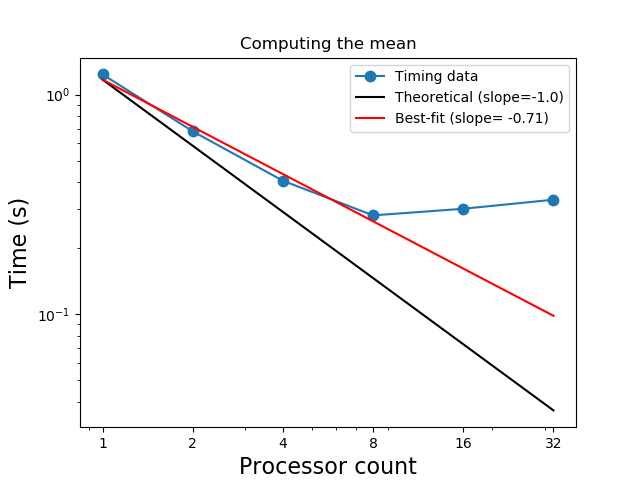

In [22]:
plt.loglog(df['Procs'],df['Time'],'.-',markersize=15,label='Timing data')

plt.xlabel('Processor count',fontsize=16)
plt.ylabel('Time (s)',fontsize=16)
plt.title('Computing the mean');

### Best-fit line to data frame

In [24]:
t_strong = df['Time'].values
c = polyfit(log(procs[:4]),log(t_strong[:4]),1)
plt.loglog(procs,exp(polyval(c,log(procs))),'r-',label='Best-fit (slope={:6.2f})'.format(c[0]))

Add the theoretical slope for comparison

In [23]:
c[0] = -1
plt.loglog(procs,exp(polyval(c,log(procs))),'k-',label='Theoretical (slope=-1.0)')

Add a legend and fix the xticks. 

In [25]:
plt.legend()

# Make nice tick marks
pstr = (['{:d}'.format(int(p)) for p in procs])
plt.xticks(procs,pstr);